In [1]:
import pandas as pd
import pybasilica.run as run
import torch
import pyro
import numpy as np
import seaborn as sns
import sklearn.metrics

%load_ext autoreload
%autoreload 2

/Users/elenab/Library/r-miniconda-arm64/envs/basilica-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m_path = "test_simul_counts.csv"
m_g = pd.read_csv(m_path)
m = m_g.drop(["groups", "groups_rare"], axis=1)
g = m_g["groups"].tolist()
g_rare = m_g["groups_rare"].tolist()
ref_path = "COSMIC_filt.csv"
cosmic = pd.read_csv(ref_path, index_col=0)
k_list = [4]  # true is 4
cluster = [4]  # true is 3 + 1 rare 

In [53]:
one = run.fit(
    x=m, 
    k_list=k_list, 
    lr=0.005, 
    n_steps=1500, 
    enumer="parallel", 
    cluster=cluster, 
    # groups=[i-1 for i in g], 
    beta_fixed=cosmic.loc[["SBS1","SBS5"]], 
    # hyperparameters={"alpha_noise_var":0.05},
    compile_model = False, 
    CUDA = False, 
    enforce_sparsity = False, 
    regularizer = "cosine", 
    reg_weight = 0., 
    reg_bic = True, 
    store_parameters=False, 
    verbose = False, 
    stage = "", 
    save_runs_seed=True,
    seed=[17],
    initializ_pars_fit = False,
    initializ_seed = False,
    new_hier=True, 
    nonparametric=False
    )

obj = one[0] 
# 5 = n_samples, 1,2 + 2 = n_sigs, 2 = n_groups 

Running model with 4 signatures, 4 groups and 17 seed

N parameters 1312


In [54]:
print({i:obj.groups.count(i) for i in set(obj.groups)})
print({i:g_rare.count(i) for i in set(g_rare)})
print({i:g.count(i) for i in set(g)} ) 


{0: 42, 1: 35, 2: 1, 3: 72}
{1: 55, 2: 45, 3: 42, 4: 8}
{1: 63, 2: 45, 3: 42}


In [55]:
print(sklearn.metrics.normalized_mutual_info_score(obj.groups, g_rare))
print(sklearn.metrics.adjusted_rand_score(obj.groups, g_rare), "\n")
print(sklearn.metrics.normalized_mutual_info_score(obj.groups, g))
print(sklearn.metrics.adjusted_rand_score(obj.groups, g))


0.6605000969388534
0.5371474117430756 

0.6774734562907999
0.5468677996942793


In [56]:
idxs = [i for i, v in enumerate(g_rare) if v == 4]
print([v for i, v in enumerate(obj.groups) if i in idxs])


[1, 1, 1, 1, 1, 1, 1, 1]


<Axes: >

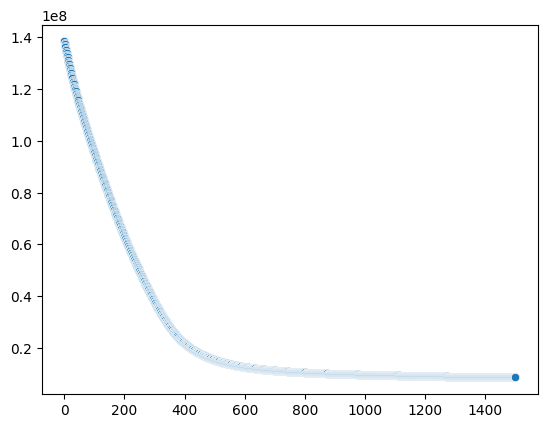

In [57]:
sns.scatterplot(x=range(len(obj.losses)), y=obj.losses)

<Axes: >

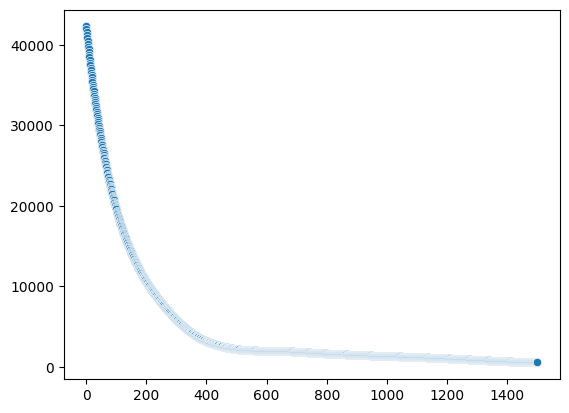

In [58]:
sns.scatterplot(x=range(len(obj.gradient_norms["alpha_prior_param"])), y=obj.gradient_norms["alpha_prior_param"]) 

In [59]:
try: sns.scatterplot(x=range(len(obj.gradient_norms["alpha_noise_param"])), y=obj.gradient_norms["alpha_noise_param"])
except: print()

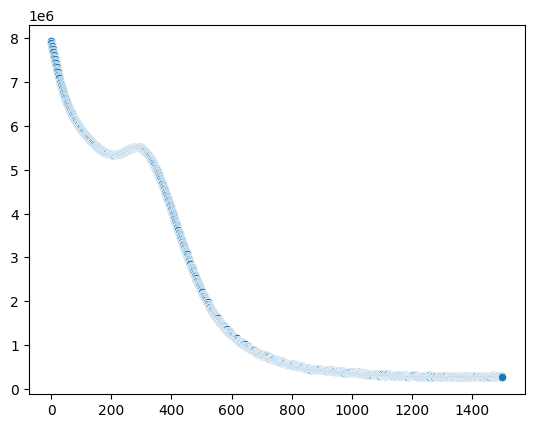

In [60]:
try: sns.scatterplot(x=range(len(obj.gradient_norms["beta_denovo"])), y=obj.gradient_norms["beta_denovo"])
except: print()

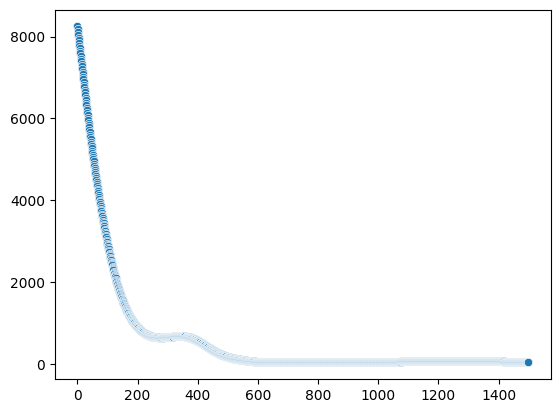

In [61]:
try: sns.scatterplot(x=range(len(obj.gradient_norms["pi_param"])), y=obj.gradient_norms["pi_param"]) 
except: print()

<Axes: >

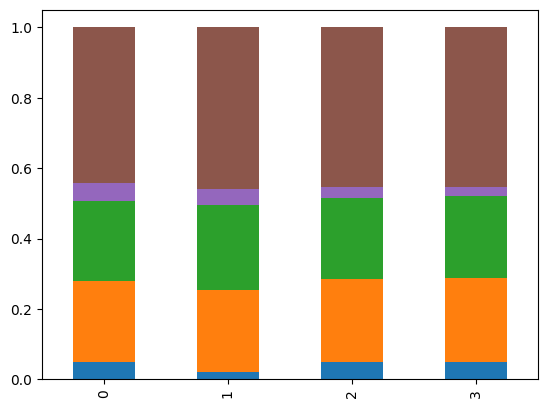

In [62]:
pd.DataFrame(np.array(obj.alpha_prior), columns=obj.alpha.columns).plot.bar(stacked=True, legend=False) 

In [63]:
print(obj.alpha_prior)
print(obj.init_params["alpha_prior_param"])
print(pyro.param("alpha_prior_param"))

tensor([[0.0491, 0.2312, 0.2273, 0.0000, 0.0517, 0.4407],
        [0.0201, 0.2337, 0.2412, 0.0000, 0.0459, 0.4591],
        [0.0496, 0.2360, 0.2306, 0.0000, 0.0315, 0.4523],
        [0.0505, 0.2374, 0.2339, 0.0000, 0.0247, 0.4536]], dtype=torch.float64)
tensor([[0.0621, 1.5059, 1.5236, 0.0328, 2.7618, 0.3396],
        [0.7377, 0.8514, 0.1295, 0.7956, 0.8045, 0.5726],
        [0.0688, 0.1900, 1.3291, 0.0747, 0.0452, 1.1671],
        [0.4694, 1.2024, 1.8049, 0.6797, 0.7729, 0.3203]], dtype=torch.float64)
tensor([[0.4156, 1.1921, 1.1753, 0.2061, 0.4267, 2.0855],
        [0.3595, 1.1831, 1.2118, 0.2820, 0.4590, 2.0516],
        [0.4147, 1.2000, 1.1773, 0.2058, 0.3384, 2.1110],
        [0.4155, 1.1889, 1.1746, 0.2066, 0.3088, 2.0836]], dtype=torch.float64,
       grad_fn=<AddBackward0>)


In [ ]:
for gid in set(obj.groups):
    tmp = [i for i, v in enumerate(obj.groups) if v == gid]
    pd.DataFrame(np.array(obj.alpha_noise), columns=obj.alpha.columns).iloc[tmp].plot.bar(stacked=True) 
# pd.DataFrame(np.array(obj.alpha_noise), columns=obj.alpha.columns).iloc[idxs].plot.bar(stacked=True, legend=False)


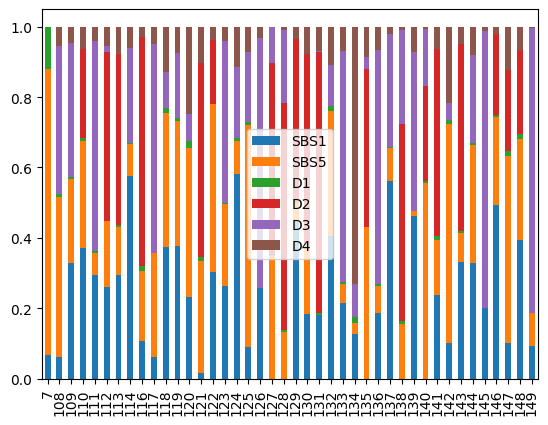

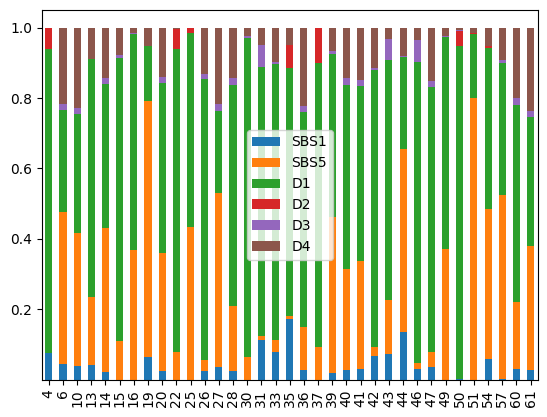

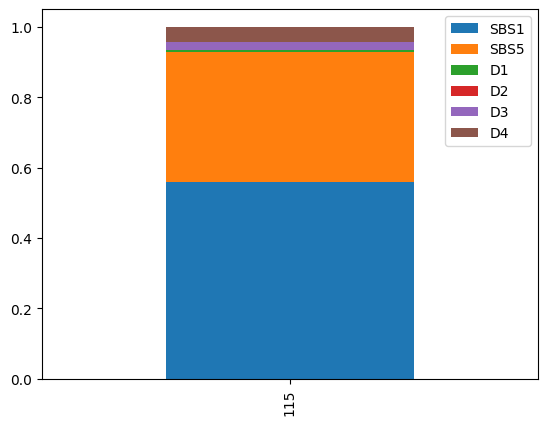

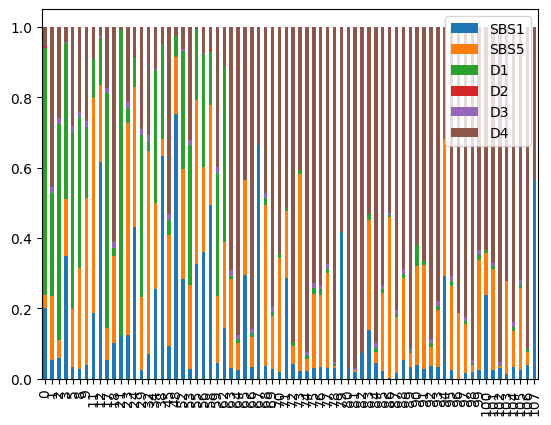

In [65]:
for gid in set(obj.groups):
    tmp = [i for i, v in enumerate(obj.groups) if v == gid]
    # tmp = [i for i, v in enumerate(obj.groups) if (v == gid and i in idxs)]
    if len(tmp) == 0: continue
    obj.alpha.iloc[tmp].plot.bar(stacked=True)
# obj.alpha.iloc[idxs].plot.bar(stacked=True, legend=False)


In [40]:
print(obj.alpha_noise.min())
print(obj.alpha_noise.max())

tensor(3.8637e-05, dtype=torch.float64)
tensor(0.6641, dtype=torch.float64)


In [ ]:
obj.pi

In [ ]:
obj.post_probs 

In [ ]:
import torch

In [ ]:
isinstance(obj.pi, torch.Tensor)

In [ ]:
obj.post_probs

In [ ]:
obj.groups 

In [ ]:
obj.alpha

In [ ]:
obj.k_denovo

In [ ]:
obj.k_fixed

In [ ]:
obj.alpha_prior_unn

In [ ]:
obj.alpha_noise

In [ ]:
obj.alpha_unn + obj.alpha_noise 

In [ ]:
obj.alpha 

In [ ]:
from pyro import distributions as distr
import seaborn as sns
import numpy as np

# sns.displot(distr.HalfNormal(obj.hyperparameters["alpha_var"]).sample_n(1000).tolist())
# sns.displot(distr.Exponential(obj.hyperparameters["exp_rate"]).sample_n(1000).tolist()) 
vars = distr.Normal(0, 0.005).sample_n(50).tolist()
centrs = [distr.Normal(0.5, np.abs(v_i)).sample().tolist() for v_i in vars]

pl = sns.scatterplot(x=vars, y=centrs)
pl.axhline(0.5-0.05)
pl.axhline(0.5+0.05)

# sns.displot(vars)
# sns.displot(distr.Normal(0, 0.01).sample_n(1000).tolist()) 

In [ ]:
sns.displot(distr.Normal(0, 0.005).sample_n(1000).tolist()) 

In [ ]:
x2 = one.epsilon.astype(int)

In [ ]:
two = run.fit(
    x=x2, 
    k_list=[1,2,3,4,5], 
    lr=0.05, 
    n_steps=500, 
    enumer=False, 
    cluster=None, 
    groups=None, 
    beta_fixed=None, 
    compile_model = False, 
    CUDA = False, 
    enforce_sparsity = False, 
    regularizer = "cosine", 
    reg_weight = 1, 
    reg_bic = False, 
    store_parameters=False, 
    verbose=False, 
    stage = "two"
    )

In [ ]:
two.alpha

In [ ]:
import torch
import numpy as np

m1 = torch.tensor(m.values).float()
alpha1 = torch.tensor(one.alpha.values).float()
a1 = torch.matmul(torch.diag(torch.sum(m1, axis=1)), alpha1)

m2 = torch.tensor(x2.values).float()
alpha2 = torch.tensor(two.alpha.values).float()
a2 = torch.matmul(torch.diag(torch.sum(m2, axis=1)), alpha2)

b1 = torch.sum(a1, 1).unsqueeze(-1)
b2 = torch.sum(a2, 1).unsqueeze(-1)
b3 = b1 + b2

alpha1 = a1 / b3
alpha2 = a2 / b3

In [ ]:
sample_names = list(one.alpha.index)
fixed_names = list(one.alpha.columns)
denovo_names = list(two.alpha.columns)
alpha1 = pd.DataFrame(np.array(alpha1), index=sample_names, columns=fixed_names)
alpha2 = pd.DataFrame(np.array(alpha2), index=sample_names, columns=denovo_names)
alpha = pd.concat([alpha1, alpha2], axis=1)

In [ ]:
alpha

In [ ]:
torch.sum(torch.tensor(alpha.values).float(), 1).unsqueeze(-1)